<a href="https://colab.research.google.com/github/mentalinvestor/EDA_2022S_Project/blob/main/Global_emp_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-11-20ab7cc9ee87>:352: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.daily_returns = self.prices.pct_change()



=== Strategic Portfolio Optimization Analysis ===

1. Asset Allocation Strategy
     Current Maximum Return Minimum Annual Loss
AOR    7.00%          7.98%              10.00%
BOTZ   4.00%         10.00%               3.00%
AIQ    3.00%         10.00%               3.00%
ARKK   4.00%         10.00%               3.00%
GAA    7.00%          3.00%              10.00%
GMOM  11.00%          3.00%              10.00%
QQQ    4.00%         10.00%               3.09%
TLT   10.00%          3.00%               7.91%
TIPS  10.00%         10.00%              10.00%
SDY    5.00%          9.98%              10.00%
DVY    5.00%          9.99%              10.00%
DIAL  15.00%          3.00%              10.00%
PDBC  15.00%          9.95%              10.00%

2. Performance Analytics
                       current   max_return     min_loss
Total Return       3604130.13%  4593935.43%  3690018.24%
Annual Return          464.31%      487.35%      466.50%
Worst Annual Loss        0.00%       -6.25%       

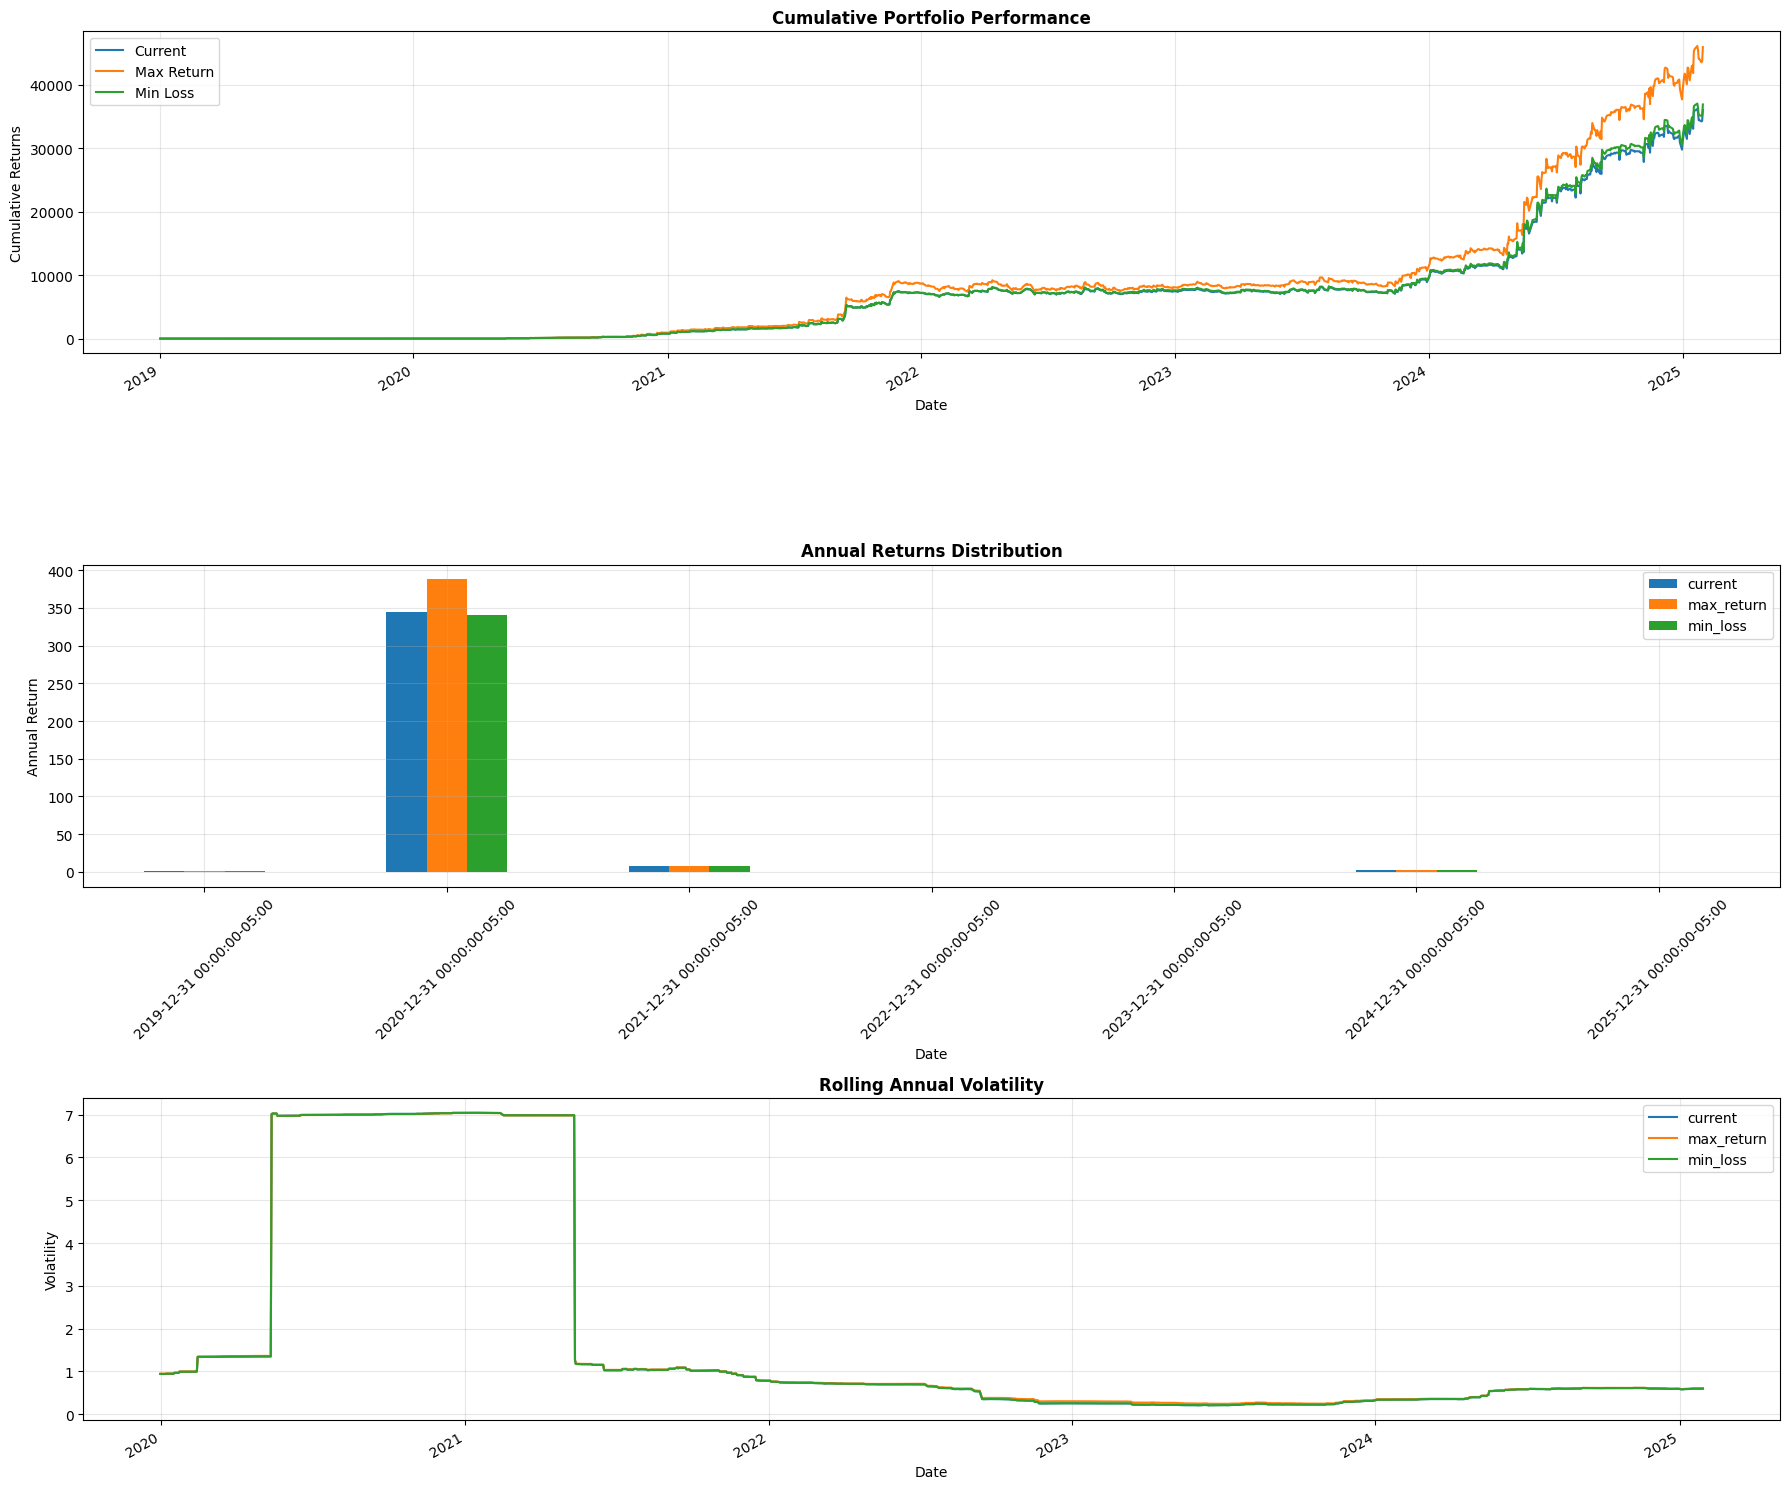

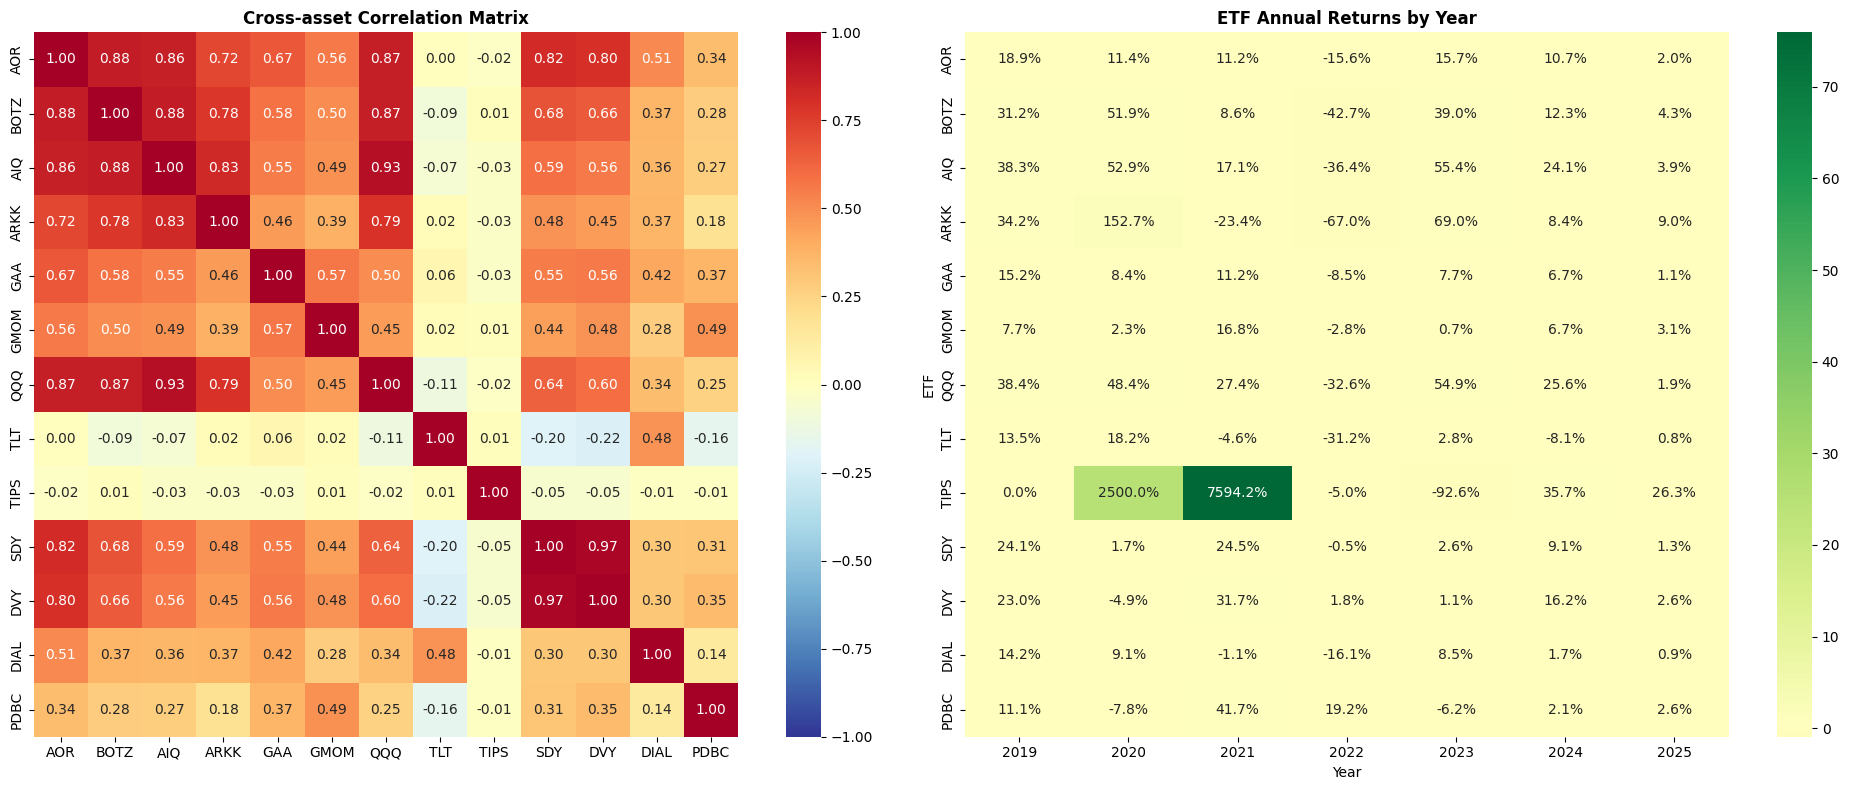


=== Cross-asset Correlation Analysis ===

Average Correlation by Asset:
TLT: 0.057
TIPS: 0.060
PDBC: 0.293
DIAL: 0.374
GMOM: 0.437
GAA: 0.482
ARKK: 0.495
DVY: 0.497
SDY: 0.502
QQQ: 0.547
AIQ: 0.555
BOTZ: 0.569
AOR: 0.616

Top 5 Diversifying Pairs (Lowest Correlation):
TLT - DVY: -0.220
TLT - SDY: -0.200
TLT - PDBC: -0.160
QQQ - TLT: -0.110
BOTZ - TLT: -0.090

=== ETF Risk-Adjusted Performance Analytics ===
                       AOR     BOTZ      AIQ     ARKK      GAA     GMOM      QQQ      TLT      TIPS      SDY      DVY     DIAL     PDBC
Annualized Return    8.32%   12.29%   20.86%    9.29%    6.63%    5.53%   22.93%   -2.87%   146.92%    9.90%   11.08%    2.32%    9.13%
Volatility          11.81%   27.74%   25.20%   44.99%   12.65%   13.26%   24.29%   17.05%  2926.11%   19.80%   20.95%    7.96%   18.92%
Sharpe Ratio          0.70     0.44     0.83     0.21     0.52     0.42     0.94    -0.17      0.05     0.50     0.53     0.29     0.48
Maximum Drawdown   -22.95%  -55.54%  -44.66% 

In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import skew, kurtosis
from scipy.optimize import minimize

class EMPPortfolioBacktest:
    """Enhanced Multi-asset Portfolio (EMP) Backtesting System

    A quantitative framework for portfolio optimization with dual objectives:
    1. Absolute Return Maximization
    2. Annual Loss Minimization

    Implements institutional-grade position limits and risk management constraints.
    """

    def __init__(self, tickers_weights_dict, start_date='2019-01-01'):
        self.tickers = list(tickers_weights_dict.keys())
        self.weights = list(tickers_weights_dict.values())
        self.start_date = start_date
        self.end_date = datetime.now().strftime('%Y-%m-%d')

    def fetch_data(self):
        """Acquire historical price data with robust error handling"""
        df_list = []
        for ticker in self.tickers:
            try:
                etf = yf.Ticker(ticker)
                data = etf.history(start=self.start_date, end=self.end_date)['Close']
                df_list.append(data)
            except Exception as e:
                print(f"Error fetching data for {ticker}: {str(e)}")
                return None

        self.prices = pd.concat(df_list, axis=1)
        self.prices.columns = self.tickers
        return self.prices

    def calculate_portfolio_metrics(self, weights):
        """
        Calculate comprehensive portfolio analytics including:
        - Return metrics (total, annual, monthly)
        - Risk metrics (volatility, annual loss)
        - Distribution characteristics
        """
        portfolio_returns = (self.daily_returns * weights).sum(axis=1)
        cumulative_returns = (1 + portfolio_returns).cumprod()

        total_return = (1 + portfolio_returns).prod() - 1
        annual_return = (1 + total_return) ** (252/len(portfolio_returns)) - 1

        # Risk metrics
        volatility = portfolio_returns.std() * np.sqrt(252)
        monthly_returns = portfolio_returns.resample('ME').apply(
            lambda x: (1 + x).prod() - 1)

        # Annual loss analysis
        annual_returns = portfolio_returns.resample('YE').apply(
            lambda x: (1 + x).prod() - 1)
        annual_losses = annual_returns[annual_returns < 0]
        worst_annual_loss = annual_losses.min() if len(annual_losses) > 0 else 0

        return {
            'returns': portfolio_returns,
            'cumulative_returns': cumulative_returns,
            'total_return': total_return,
            'annual_return': annual_return,
            'volatility': volatility,
            'worst_annual_loss': worst_annual_loss,
            'monthly_returns': monthly_returns
        }

    def optimize_portfolio(self):
        """
        Execute portfolio optimization with institutional constraints:
        - Position limits: 3-25% per asset
        - Full investment constraint
        - Long-only positions
        """
        n_assets = len(self.tickers)
        bounds = tuple((0.03, 0.1) for _ in range(n_assets))
        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]

        # Return maximization strategy
        def objective_return(weights):
            metrics = self.calculate_portfolio_metrics(weights)
            return -metrics['total_return']

        max_return_result = minimize(
            objective_return,
            np.array([1/n_assets] * n_assets),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': 1000}
        )

        # Annual loss minimization strategy
        def objective_annual_loss(weights):
            portfolio_returns = (self.daily_returns * weights).sum(axis=1)
            annual_returns = portfolio_returns.resample('YE').apply(
                lambda x: (1 + x).prod() - 1)
            annual_losses = annual_returns[annual_returns < 0]

            if len(annual_losses) == 0:
                return 0

            worst_loss = annual_losses.min()
            avg_loss = annual_losses.mean()
            return abs(worst_loss) + 0.5 * abs(avg_loss)

        min_loss_result = minimize(
            objective_annual_loss,
            np.array([1/n_assets] * n_assets),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': 1000}
        )

        # Store optimization results
        self.max_return_weights = max_return_result.x
        self.min_loss_weights = min_loss_result.x

        # Calculate and store portfolio metrics
        self.strategy_metrics = {
            'current': self.calculate_portfolio_metrics(np.array(self.weights)),
            'max_return': self.calculate_portfolio_metrics(self.max_return_weights),
            'min_loss': self.calculate_portfolio_metrics(self.min_loss_weights)
        }

        self._generate_performance_report()

    def _generate_performance_report(self):
        """Generate comprehensive portfolio analytics report"""
        # 1. Strategic allocation analysis
        allocation_df = pd.DataFrame({
            'Current': [f'{w:.2%}' for w in self.weights],
            'Maximum Return': [f'{w:.2%}' for w in self.max_return_weights],
            'Minimum Annual Loss': [f'{w:.2%}' for w in self.min_loss_weights]
        }, index=self.tickers)

        print("\n=== Strategic Portfolio Optimization Analysis ===")
        print("\n1. Asset Allocation Strategy")
        print(allocation_df.to_string())

        # 2. Performance analytics
        performance_data = {}
        for strategy, metrics in self.strategy_metrics.items():
            performance_data[strategy] = [
                f"{metrics['total_return']:.2%}",
                f"{metrics['annual_return']:.2%}",
                f"{metrics['worst_annual_loss']:.2%}",
                f"{metrics['volatility']:.2%}"
            ]

        performance_df = pd.DataFrame(
            performance_data,
            index=['Total Return', 'Annual Return', 'Worst Annual Loss', 'Volatility']
        )

        print("\n2. Performance Analytics")
        print(performance_df.to_string())

    def plot_performance(self):
        """Generate sophisticated portfolio visualization analytics"""
        # Setup main performance plots
        fig1, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 15))

        # 1. Cumulative returns analysis
        for strategy, metrics in self.strategy_metrics.items():
            metrics['cumulative_returns'].plot(
                ax=ax1,
                label=strategy.replace('_', ' ').title()
            )

        ax1.set_title('Cumulative Portfolio Performance', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Cumulative Returns')
        ax1.grid(True, alpha=0.3)
        ax1.legend()

        # 2. Annual returns comparison
        annual_returns = pd.DataFrame({
            strategy: metrics['returns'].resample('YE').apply(lambda x: (1 + x).prod() - 1)
            for strategy, metrics in self.strategy_metrics.items()
        })

        annual_returns.plot(kind='bar', ax=ax2)
        ax2.set_title('Annual Returns Distribution', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Annual Return')
        ax2.grid(True, alpha=0.3)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

        # 3. Rolling volatility analysis
        window = 252
        rolling_vol = pd.DataFrame({
            strategy: metrics['returns'].rolling(window=window).std() * np.sqrt(252)
            for strategy, metrics in self.strategy_metrics.items()
        })

        rolling_vol.plot(ax=ax3)
        ax3.set_title('Rolling Annual Volatility', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Volatility')
        ax3.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Create correlation and returns heatmap
        fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # Correlation Matrix Heatmap
        correlation_matrix = self.daily_returns.corr().round(2)
        sns.heatmap(correlation_matrix,
                   annot=True,
                   cmap='RdYlBu_r',
                   center=0,
                   vmin=-1,
                   vmax=1,
                   ax=ax1,
                   fmt='.2f',
                   square=True)
        ax1.set_title('Cross-asset Correlation Matrix', fontsize=12, fontweight='bold')

        # Annual Returns Heatmap
        annual_etf_returns = pd.DataFrame()
        for col in self.daily_returns.columns:
            annual_rets = self.daily_returns[col].resample('YE').apply(
                lambda x: (1 + x).prod() - 1)
            annual_etf_returns[col] = annual_rets

        # Format the index to show only years
        annual_etf_returns.index = annual_etf_returns.index.year

        sns.heatmap(annual_etf_returns.T,
                   annot=True,
                   cmap='RdYlGn',
                   center=0,
                   fmt='.1%',
                   ax=ax2)
        ax2.set_title('ETF Annual Returns by Year', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('ETF')

        plt.tight_layout()
        plt.show()

        # Print cross-sectional analysis
        print("\n=== Cross-asset Correlation Analysis ===")

        # Calculate and sort average correlations
        avg_corr = correlation_matrix.mean().sort_values()
        print("\nAverage Correlation by Asset:")
        for asset, corr in avg_corr.items():
            print(f"{asset}: {corr:.3f}")

        # Identify optimal diversification pairs
        min_corr_pairs = []
        for i in range(len(self.tickers)):
            for j in range(i+1, len(self.tickers)):
                min_corr_pairs.append((
                    self.tickers[i],
                    self.tickers[j],
                    correlation_matrix.iloc[i,j]
                ))

        min_corr_pairs.sort(key=lambda x: x[2])

        print("\nTop 5 Diversifying Pairs (Lowest Correlation):")
        for pair in min_corr_pairs[:5]:
            print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")

        # Print comprehensive ETF analytics
        print("\n=== ETF Risk-Adjusted Performance Analytics ===")
        etf_stats = pd.DataFrame()
        for col in self.daily_returns.columns:
            returns = self.daily_returns[col]
            annualized_return = (1 + returns).prod() ** (252/len(returns)) - 1
            annualized_vol = returns.std() * np.sqrt(252)
            sharpe_ratio = annualized_return / annualized_vol
            max_drawdown = (1 + returns).cumprod().div(
                (1 + returns).cumprod().cummax()).min() - 1

            etf_stats[col] = [
                f"{annualized_return:.2%}",
                f"{annualized_vol:.2%}",
                f"{sharpe_ratio:.2f}",
                f"{max_drawdown:.2%}"
            ]

        etf_stats.index = ['Annualized Return', 'Volatility', 'Sharpe Ratio', 'Maximum Drawdown']
        print(etf_stats.to_string())

        # Print correlation analysis summary
        print("\n=== Cross-asset Correlation Analysis ===")

        # Calculate average correlations for each asset
        avg_corr = correlation_matrix.mean().sort_values()
        print("\nAverage Correlation by Asset:")
        for asset, corr in avg_corr.items():
            print(f"{asset}: {corr:.3f}")

        # Identify strongest diversifiers
        min_corr_pairs = []
        for i in range(len(self.tickers)):
            for j in range(i+1, len(self.tickers)):
                min_corr_pairs.append((
                    self.tickers[i],
                    self.tickers[j],
                    correlation_matrix.iloc[i,j]
                ))

        min_corr_pairs.sort(key=lambda x: x[2])

        print("\nTop 5 Diversifying Pairs:")
        for pair in min_corr_pairs[:5]:
            print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")

        # Print ETF performance summary
        print("\n=== ETF Performance Analytics ===")
        etf_stats = pd.DataFrame()
        for col in self.daily_returns.columns:
            returns = self.daily_returns[col]
            annualized_return = (1 + returns).prod() ** (252/len(returns)) - 1
            annualized_vol = returns.std() * np.sqrt(252)
            sharpe_ratio = annualized_return / annualized_vol

            etf_stats[col] = [
                f"{annualized_return:.2%}",
                f"{annualized_vol:.2%}",
                f"{sharpe_ratio:.2f}"
            ]

        etf_stats.index = ['Annualized Return', 'Annualized Volatility', 'Sharpe Ratio']
        print(etf_stats.to_string())

        # Print annual performance statistics
        print("\n=== Annual Performance Statistics ===")
        annual_stats = annual_returns.agg(['mean', 'std', 'min', 'max']).round(4)
        annual_stats.index = ['Average Annual Return', 'Annual Return Std',
                            'Worst Annual Return', 'Best Annual Return']
        print(annual_stats.apply(lambda x: x.map('{:.2%}'.format)).to_string())

    def run_backtest(self):
        """Execute comprehensive portfolio analysis"""
        if self.fetch_data() is None:
            return

        self.daily_returns = self.prices.pct_change()
        self.optimize_portfolio()
        self.plot_performance()

# Example Usage
if __name__ == "__main__":
    portfolio = {
        'AOR': 0.07,    # 자산배분 7%
        'BOTZ': 0.04,    # 로보틱스 4%
        'AIQ': 0.03,    # AI 3%
        'ARKK': 0.04,    # ARK 4
        'GAA': 0.07,    # 자산배분 2 7%
        'GMOM': 0.11,    # 자산배분 3 11%                                자산배분 25% (CORE, AOR 7, GAA 7, GMOM 11) + 주식 25% (성장주 15(BOTZ 4, ARKK 4, AIQ 3, QQQ 4) + 배당주 10 중심) + 채권 35% + 오버레이로 원자재 15%
        'QQQ': 0.04,    # 나스닥 10%
        'TLT': 0.1,    # 채권 10%
        'TIP': 0.1,    # 팁스 10%
        'SDY': 0.05,    # 배당 5%
        'DVY': 0.05,   # 배당 5%
        'DIAL': 0.15,    # 채권 15%
        'PDBC' : 0.15 # 원자재 15%
    }

    backtest = EMPPortfolioBacktest(portfolio)
    backtest.run_backtest()


    # Example Usage
#if __name__ == "__main__":
 #   portfolio = {
  #      'VTI': 0.15,    # US Total Market
   #     'VWO': 0.10,    # Emerging Markets
   #     'QQQ': 0.10,    # NASDAQ 100
    #    'VGT': 0.10,    # Technology Sector
     #   'GLD': 0.08,    # Gold
      #  'DBC': 0.07,    # Commodities
       # 'AGG': 0.15,    # US Aggregate Bonds
      #  'TIP': 0.10,    # TIPS
      #  'VCSH': 0.08,   # Short-term Corporate Bonds
     #   'PDBC': 0.07    # Commodity Strategy
   # }

In [ ]:
##